In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets
from scipy.spatial import distance
from geopy.distance import geodesic
from geopy.geocoders import Nominatim


-----
### Utils function

In [2]:
def PCA(df, label):
    # Standardizse the features
    df_norm = (df-df.mean())/df.std()
    print('Normalized data')
    #display(df_norm)


    # Apply PCA
    pca = decomposition.PCA(n_components=4)
    PCA_df = pd.DataFrame(data = pca.fit_transform(df_norm), columns=['Component #1', 'Component #2', 'Component #3', 'Component #4'])
    print("After PCA")
    print("Singular values:", pca.singular_values_)
    #display(PCA_df)


    # Append the target Label columns
    target = pd.Series(label , name='label')

    df = pd.concat([df, target], axis = 1)
    PCA_df = pd.concat([PCA_df, target], axis = 1)
    return PCA_df

In [3]:
def PCA_plot(PCA_df, comp=[0, 1], targets=['UK', 'FR']):
    x = PCA_df.iloc[:,comp[0]]
    y = PCA_df.iloc[:,comp[1]]

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.25]
    rect_histy = [left_h, bottom, 0.25, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(12, 12))

    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # the scatter plot:
    for _, idt  in enumerate(targets):
        axScatter.scatter(PCA_df[PCA_df['label'] == idt].iloc[:,comp[0]], 
                          PCA_df[PCA_df['label'] == idt].iloc[:,comp[1]])


    # now determine nice limits by hand:
    binwidth = 0.2
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
    lim = (int(xymax/binwidth) + 1) * binwidth

    axScatter.set_xlim((-lim, lim))
    axScatter.set_ylim((-lim, lim))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    axHistx.hist(x, bins=bins)
    axHisty.hist(y, bins=bins, orientation='horizontal')

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

    axHistx.set_xticks([])
    axHisty.set_yticks([])

    axScatter.legend(targets)
    axScatter.grid()
    axScatter.set_xlabel('Component #'+str(comp[0]), fontsize = 15)
    axScatter.set_ylabel('Component #'+str(comp[1]), fontsize = 15)
    plt.savefig('./figures/realdata'+str(comp[0])+str(comp[1])+'.png')
    plt.show()

----
### Data Loading / merging

### UK

In [4]:
# Data loading:
UK_covid_df = pd.read_csv("./data/UK/UK_covid.csv")
UK_covid_df['coord'] = UK_covid_df[['lat','lon']].apply(tuple, axis=1)
UK_covid_df = UK_covid_df.drop(columns= ['lat', 'lon'])
#UK_covid_df

UK_pol_df = pd.read_csv("./data/UK/UK_pol_pop.csv")
UK_pol_df['coord'] = UK_pol_df[['lat','lon']].apply(tuple, axis=1)
UK_pol_df = UK_pol_df.drop(columns= ['lat', 'lon'])
#UK_pol_df.head()

n = UK_covid_df.shape[0]
m = UK_pol_df.shape[0]
UK_covid_df['sensor_site_name'] = np.zeros(n)
UK_covid_df['distance from the sensor [km]'] = np.zeros(n)
dist_vect = np.zeros(m)
#associating a station to each UK_covid_df
for idx1, row1 in UK_covid_df.iterrows():
    pos1= np.array(row1['coord'])
    for idx2, row2 in UK_pol_df.iterrows():
        pos2 = np.array(row2['coord']) #position of the sensor
        dst = distance.euclidean(pos1, pos2)
        dist_vect[idx2] = dst
    idx_min = np.where(dist_vect == np.amin(dist_vect))[0][0]
    UK_covid_df.loc[idx1, 'sensor_site_name'] = UK_pol_df.loc[idx_min,'site']
    p = row1['coord'] #sensor's position
    s = UK_pol_df.loc[idx_min, 'coord'] #associated sensor position
    UK_covid_df.loc[idx1, 'distance from the sensor [km]'] = geodesic(p, s).km
    
threshold = 20
UK_covid_df = UK_covid_df[UK_covid_df['distance from the sensor [km]'] < threshold]
UK_covid_dff = UK_covid_df.groupby(['sensor_site_name'], as_index=False).agg({'# death':  np.sum})

#finally merge the two datasets
UK_merged = UK_covid_dff.merge(UK_pol_df, left_on='sensor_site_name', right_on='site')
UK_merged = UK_merged[['# death', 'no2', 'pm10', 'pm2.5', 'population']]
UK_merged['death_ratio'] = UK_merged['# death']/UK_merged['population']
UK_merged = UK_merged.drop(columns=['# death','population'])
UK_merged.head()

,no2,pm10,pm2.5,death_ratio
0,31.486575,18.136199,12.977897,0.000807
1,27.290171,17.094891,12.165736,0.000447
2,64.735355,23.568150,18.968763,0.000215
3,24.618499,17.752360,11.066149,0.001736
4,25.497863,16.736710,10.123403,0.000219


### France

In [5]:
FR_pol_df = pd.read_csv("./data/France/FR_pol.csv", dtype={'# dept': object})
FR_covid_df = pd.read_csv("./data/France/FR_covid.csv")[['No', 'Département', 'Décès > 03/06']]
FR_merged = pd.merge(FR_pol_df, FR_covid_df, left_on='# dept', right_on='No')
FR_merged = FR_merged[['Décès > 03/06','NO2','PM10','PM2.5', 'population']]
FR_merged.columns = ['# death', 'no2', 'pm10', 'pm2.5', 'population']
FR_merged['death_ratio'] = FR_merged['# death']/FR_merged['population']
FR_merged = FR_merged.drop(columns=['# death','population'])
FR_merged.head() # TODO we are missing # death here from the official number :S the source is not good enough? But let us neglect that right now to continue

,no2,pm10,pm2.5,death_ratio
0,12.350000,16.250000,10.000000,0.000150
1,20.714286,17.600000,14.000000,0.000496
2,11.587500,12.166667,7.800000,0.000115
3,13.675000,11.080000,7.420000,0.000074
4,40.071429,24.973913,13.383333,0.000168


### Spain

### PCA

In [6]:
All_df = UK_merged.append(FR_merged, ignore_index=True)
label = np.hstack((["UK"]*len(UK_merged), ["FR"]*len(FR_merged)))
PCA_df = PCA(All_df, label)
PCA_df

Normalized data
After PCA
Singular values: [13.78668037  8.92002958  5.32273499  4.24605803]


,Component #1,Component #2,Component #3,Component #4,label
0,0.321387,-0.114768,0.327662,-0.184356,UK
1,-0.176743,-0.191532,0.280315,-0.145850,UK
2,3.744744,-0.364769,1.172706,-0.816095,UK
3,-0.424524,0.150923,0.125620,0.250278,UK
4,-0.753071,-0.213040,0.451212,0.353495,UK
...,...,...,...,...,...
75,-0.062446,-0.366734,-0.772883,-0.020791,FR
76,0.574317,-0.165255,0.121891,0.145188,FR
77,0.660705,-0.348915,0.367846,0.509279,FR
78,0.471681,-0.422977,-0.095148,0.675872,FR


In [7]:
All_df.shape

(80, 4)

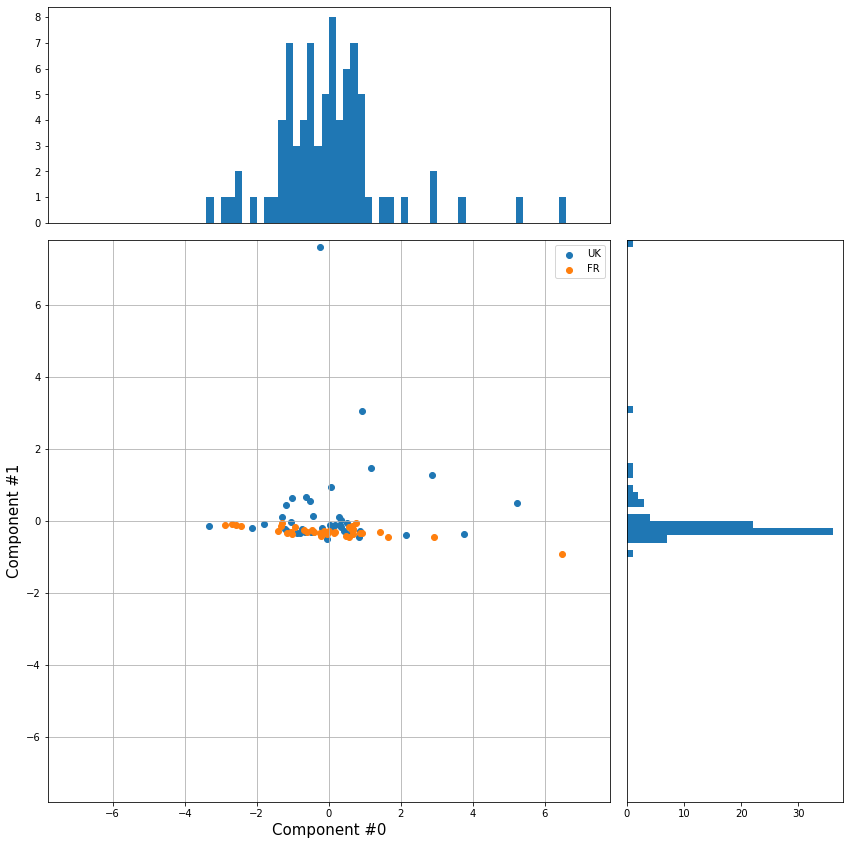

In [8]:
PCA_plot(PCA_df)

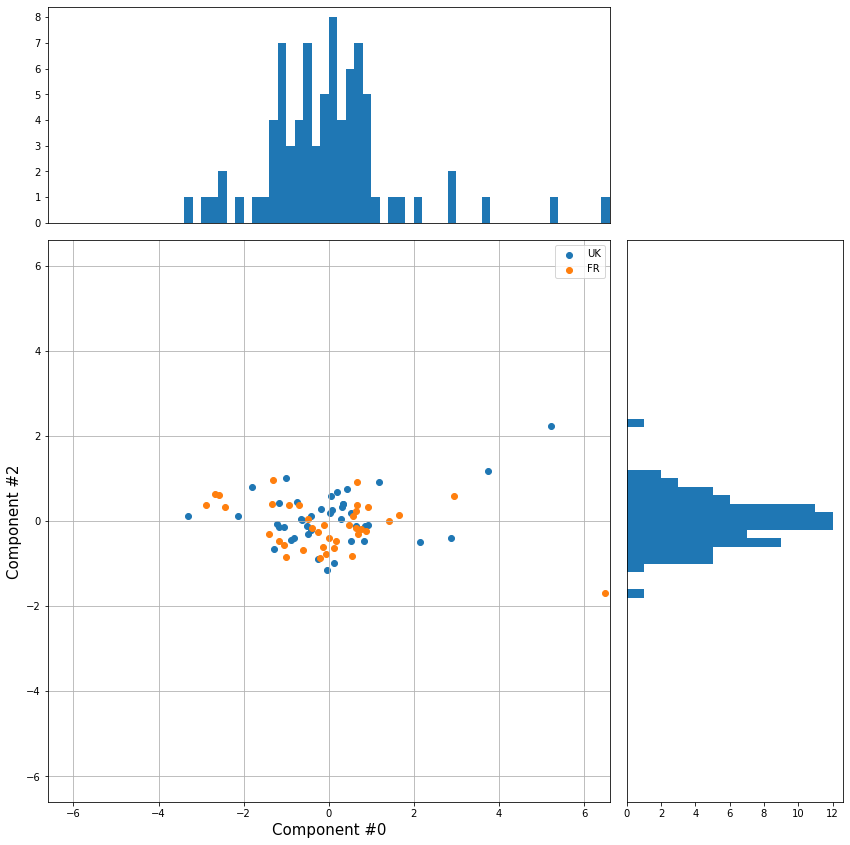

In [9]:
PCA_plot(PCA_df, [0, 2])

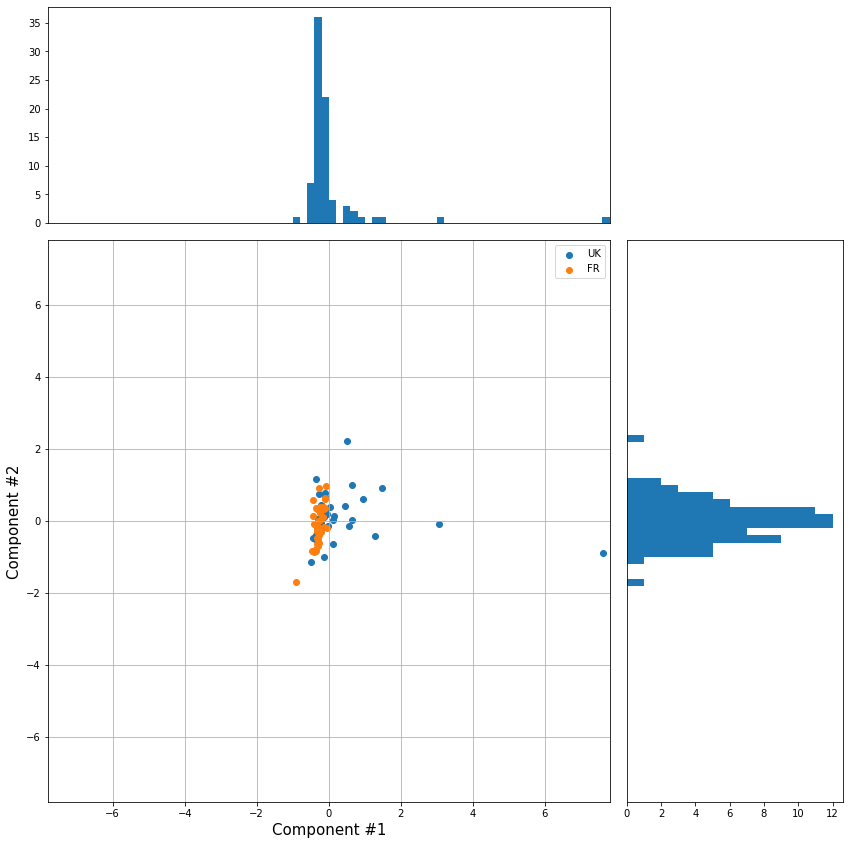

In [10]:
PCA_plot(PCA_df, [1, 2])

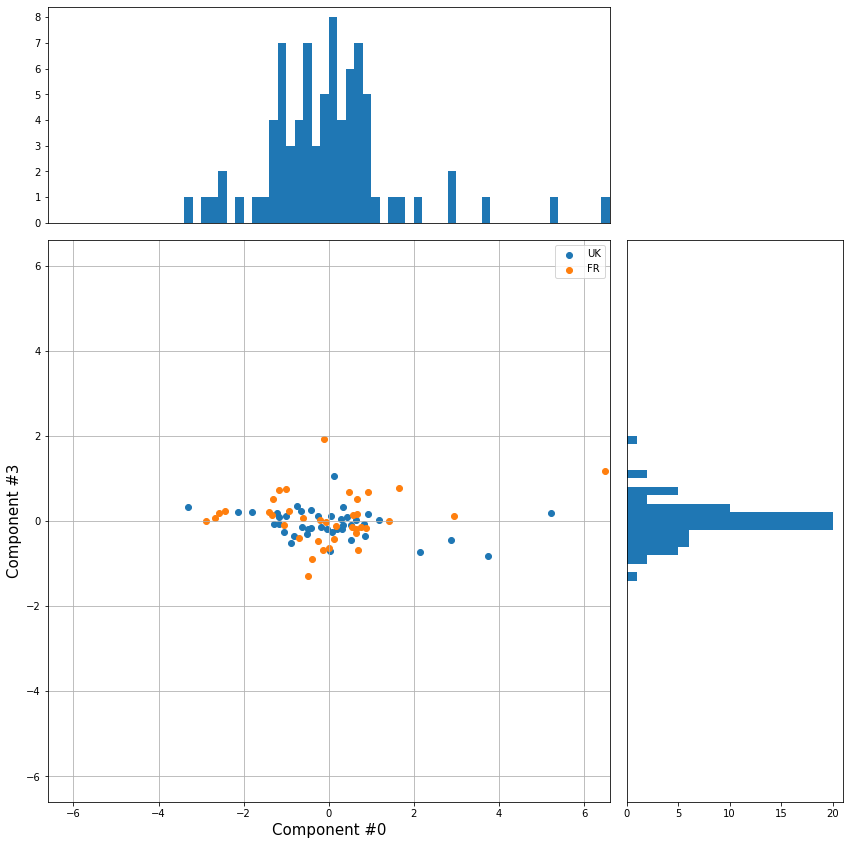

In [11]:
PCA_plot(PCA_df, [0, 3])

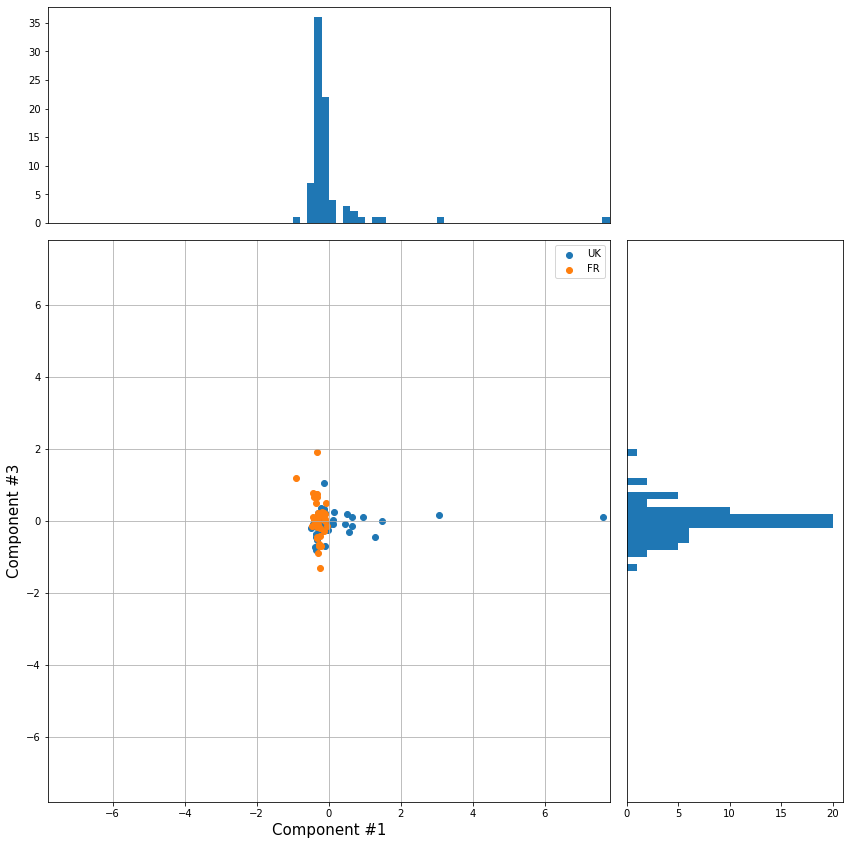

In [12]:
PCA_plot(PCA_df, [1, 3])

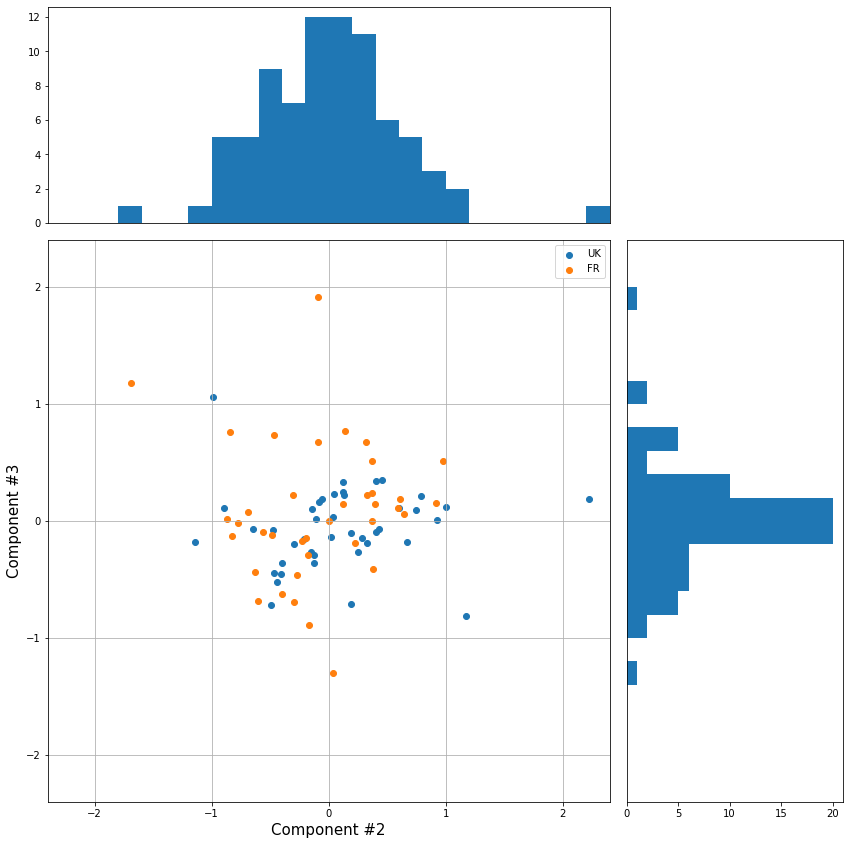

In [13]:
PCA_plot(PCA_df, [2, 3])

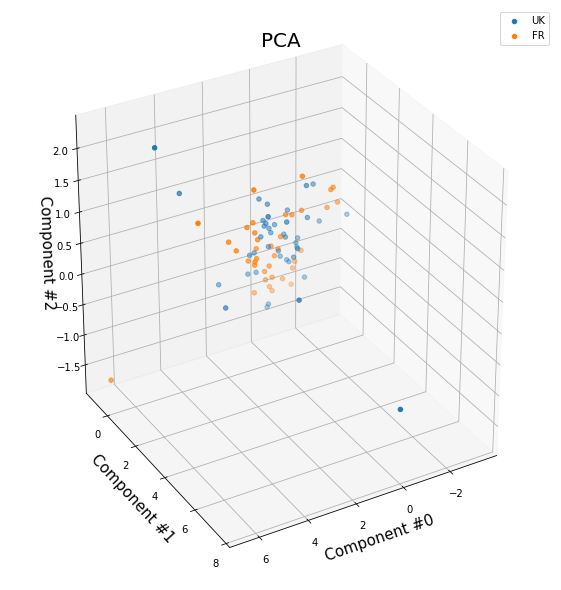

In [14]:
fig = plt.figure(figsize = (8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=30, azim=60)
df = PCA_df
targets = ['UK', 'FR']

for _, idt in enumerate(targets):
    ax.scatter(df[df['label'] == idt].iloc[:,0], 
               df[df['label'] == idt].iloc[:,1],
               df[df['label'] == idt].iloc[:,2])

ax.legend(targets)
ax.grid()
ax.set_xlabel('Component #0', fontsize = 15)
ax.set_ylabel('Component #1', fontsize = 15)
ax.set_zlabel('Component #2', fontsize = 15)
ax.set_title('PCA', fontsize = 20)
plt.show()

----
#### Confusion Matrix (this is purely a test)

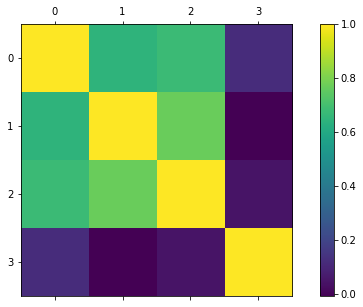

In [15]:
corrMatrix = All_df.iloc[:,:].corr()

fig, ax = plt.subplots(figsize=(10,5))
cax = ax.matshow(corrMatrix)
plt.colorbar(cax)
plt.show()

-----
**Assignment #1: Report on the test of the tool on simulated and real dataThe  report  presents  the  assigned  tool  and  its  advantages,  disadvantages,  and  limitations,  bothin  a  theoretical  as  well  as  numerical  way  with  examples  using  synthetic  data  (to  show  specificcharacteristics) and real one.**

## Limitations
#### Non linearity

In [16]:
# Synthetic data
N = 900
df = pd.DataFrame()

df['age'] = np.hstack([np.linspace(10, 50,N//2), np.linspace(50, 100,N//2)]) + np.random.normal(5, 7, N)
df['particle 1'] =  np.random.normal(10, 7,N)
df['particle 2'] =  np.hstack([np.random.normal(30, 7,N//2), np.random.normal(10, 7,N//2)])
df['death'] = np.cos(df['particle 1']**2*100 + 10*df['age'])
df['other'] = df['particle 2']*25


print('Synthetic data')
display(df)

# Standardizse the features
df_norm = (df-df.mean())/df.std()


# Apply PCA
pca = decomposition.PCA(n_components=5)
PCA_df = pd.DataFrame(data = pca.fit_transform(df_norm), columns=['Component #1', 'Component #2', 'Component #3', 'Component #4','Component #5'])
print("After PCA")
print("Singular values:", pca.singular_values_)

# Append the target Label columns
target = pd.Series(np.hstack([np.zeros(N//2),np.ones(N//2)]) , name='label')

df = pd.concat([df, target], axis = 1)
PCA_df = pd.concat([PCA_df, target], axis = 1)


Synthetic data


,age,particle 1,particle 2,death,other
0,27.941529,1.487100,30.948186,-0.498748,773.704654
1,21.064240,8.496904,45.002708,-0.871398,1125.067699
2,28.014813,2.516617,38.665802,-0.752361,966.645058
3,3.740716,7.546174,36.109521,-0.046106,902.738017
4,19.587037,18.167965,24.813957,-0.991922,620.348922
...,...,...,...,...,...
895,84.097859,2.025691,12.310964,0.567643,307.774101
896,107.220152,16.152903,7.534827,-0.047774,188.370685
897,118.060739,19.743164,16.812303,-0.637621,420.307573
898,99.803961,6.729338,10.392544,-0.929565,259.813601


After PCA
Singular values: [4.81987849e+01 3.02108769e+01 2.96502313e+01 1.94947131e+01
 3.68226801e-15]


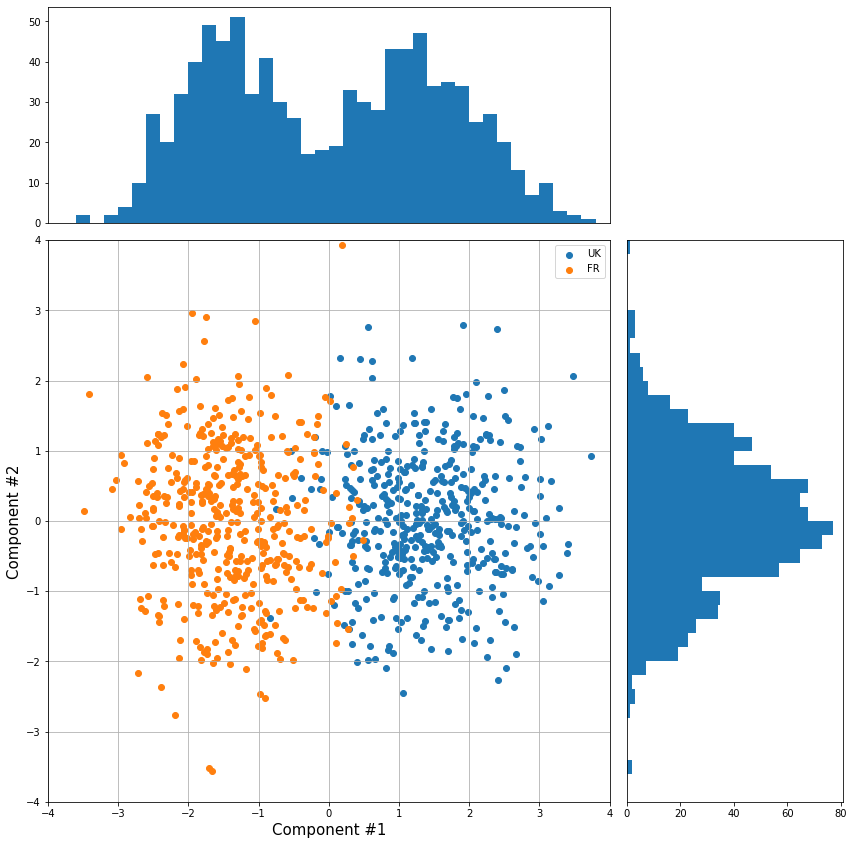

In [17]:
x = PCA_df.iloc[:,0]
y = PCA_df.iloc[:,1]

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.25]
rect_histy = [left_h, bottom, 0.25, height]

# start with a rectangular Figure
plt.figure(1, figsize=(12, 12))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels


# the scatter plot:
for idt, _ in enumerate(targets):
    axScatter.scatter(PCA_df[PCA_df['label'] == idt].iloc[:,0], 
               PCA_df[PCA_df['label'] == idt].iloc[:,1])
    

# now determine nice limits by hand:
binwidth = 0.2
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim((-lim, lim))
axScatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins)
axHisty.hist(y, bins=bins, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axHistx.set_xticks([])
axHisty.set_yticks([])

axScatter.legend(targets)
axScatter.grid()
axScatter.set_xlabel('Component #1', fontsize = 15)
axScatter.set_ylabel('Component #2', fontsize = 15)
plt.savefig('./figures/synthetic_PCA_limitation.png')
plt.show()

#### Higher dimensionality

In [18]:
# Synthetic data
N = 900
df = pd.DataFrame()

df['age'] = np.hstack([np.linspace(10, 50,N//2), np.linspace(50, 100,N//2)]) + np.random.normal(5, 7, N)
df['particle 1'] =  np.random.normal(10, 7,N)
df['particle 2'] =  np.random.normal(10, 7,N)
df['death'] = np.random.normal(10, 7,N) + df['particle 1']
df['other'] = np.random.normal(10, 7,N) + df['particle 2']


print('Synthetic data')
display(df)

# Standardizse the features
df_norm = (df-df.mean())/df.std()


# Apply PCA
pca = decomposition.PCA(n_components=5)
PCA_df = pd.DataFrame(data = pca.fit_transform(df_norm), columns=['Component #1', 'Component #2', 'Component #3', 'Component #4','Component #5'])
print("After PCA")
print("Singular values:", pca.singular_values_)

# Append the target Label columns
target = pd.Series(np.hstack([np.zeros(N//2),np.ones(N//2)]) , name='label')

df = pd.concat([df, target], axis = 1)
PCA_df = pd.concat([PCA_df, target], axis = 1)

Synthetic data


,age,particle 1,particle 2,death,other
0,14.404710,9.990448,6.175205,23.607691,14.255873
1,10.668524,20.118082,-6.077402,30.059652,7.697598
2,7.902739,19.716372,15.592638,24.241098,25.668027
3,19.852084,21.430236,7.730855,31.546035,16.584992
4,18.757349,7.871611,-1.461139,24.052961,12.546013
...,...,...,...,...,...
895,114.421982,4.865979,29.743316,24.148519,38.625029
896,97.446318,4.543723,14.836669,6.573851,12.843004
897,108.695095,3.337681,9.301759,12.329361,26.578191
898,116.203096,8.075298,11.331302,13.810242,22.378948


After PCA
Singular values: [39.41009803 38.98803695 29.84904989 16.44562814 16.13544804]


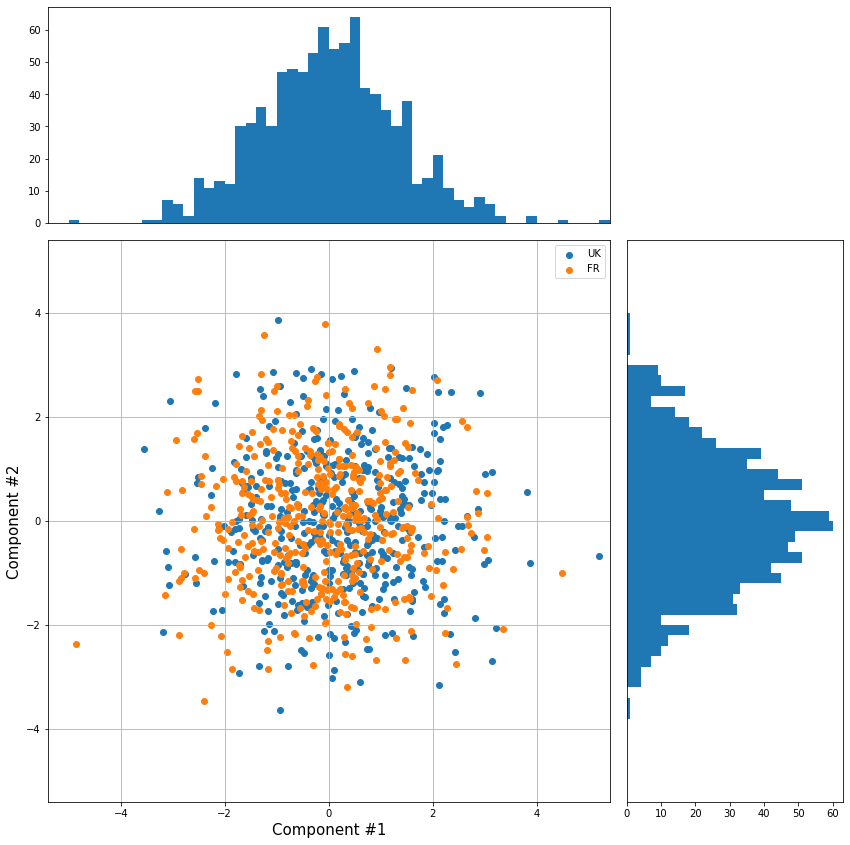

In [19]:
x = PCA_df.iloc[:,0]
y = PCA_df.iloc[:,1]

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.25]
rect_histy = [left_h, bottom, 0.25, height]

# start with a rectangular Figure
plt.figure(1, figsize=(12, 12))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels


# the scatter plot:
for idt, _ in enumerate(targets):
    axScatter.scatter(PCA_df[PCA_df['label'] == idt].iloc[:,0], 
               PCA_df[PCA_df['label'] == idt].iloc[:,1])
    

# now determine nice limits by hand:
binwidth = 0.2
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim((-lim, lim))
axScatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins)
axHisty.hist(y, bins=bins, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axHistx.set_xticks([])
axHisty.set_yticks([])

axScatter.legend(targets)
axScatter.grid()
axScatter.set_xlabel('Component #1', fontsize = 15)
axScatter.set_ylabel('Component #2', fontsize = 15)
plt.savefig('./figures/synthetic_PCA_limitation_2.png')
plt.show()

-----
# Pour les particules:

In [20]:
df_particles = pd.read_csv('./data/Spain/Particles/data.csv')  

# We can make a tuple of the Lat and Long to store it instead of merging with the city just yet
df_particles['lat_long'] = df_particles[['SamplingPoint_Latitude','SamplingPoint_Longitude']].apply(tuple, axis=1)
df_particles

,CountryOrTerritory,ReportingYear,UpdateTime,StationLocalId,SamplingPointLocalId,SamplingPoint_Latitude,SamplingPoint_Longitude,Pollutant,AggregationType,Namespace,Unit,BeginPosition,EndPosition,Validity,Verification,DataCoverage,DataCapture,TimeCoverage,AQValue,lat_long
0,Spain,2018,2019-08-31T18:56:10.456666Z,STA_ES1349A,SP_01036004_14_6,43.144070,-2.963370,Ozone (air),Summer mean,ES.BDCA.AQD,ug.m-3,2018-04-01,2018-10-01,Valid,Verified,95.195811,100.0,95.195811,44.284621,"(43.14406999999999, -2.96337)"
1,Spain,2018,2019-08-31T18:56:10.456666Z,STA_ES1635A,SP_03014006_14_6,38.359444,-0.471944,Ozone (air),Summer mean,ES.BDCA.AQD,ug.m-3,2018-04-01,2018-10-01,Valid,Verified,97.131148,100.0,97.131148,74.287389,"(38.35944444, -0.4719444400000001)"
2,Spain,2018,2019-08-31T18:56:10.456666Z,STA_ES1781A,SP_11020004_14_6,36.688550,-6.117240,Ozone (air),Summer mean,ES.BDCA.AQD,ug.m-3,2018-04-01,2018-10-01,Valid,Verified,98.178506,100.0,98.178506,80.115028,"(36.68854999999999, -6.117240000000001)"
3,Spain,2018,2019-08-31T18:56:10.456666Z,STA_ES1838A,SP_28009001_14_6,40.599700,-3.503300,Ozone (air),Summer mean,ES.BDCA.AQD,ug.m-3,2018-04-01,2018-10-01,Valid,Verified,98.884335,100.0,98.884335,82.812111,"(40.5997, -3.5033)"
4,Spain,2018,2019-08-31T18:56:10.456666Z,STA_ES1422A,SP_28079035_14_6,40.419167,-3.703333,Ozone (air),Summer mean,ES.BDCA.AQD,ug.m-3,2018-04-01,2018-10-01,Valid,Verified,95.833333,100.0,95.833333,54.003196,"(40.41916666, -3.70333333)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220489,Spain,2015,2019-02-21T23:02:29.616666Z,STA_ES1654A,SP_41088001_9_M,37.994350,-5.666870,Particulate matter < 2.5 µm (aerosol),1 year 50 %ile of daily values in a year,ES.BDCA.AQD,ug.m-3,2015-01-01,2016-01-01,Not valid,Verified,48.767123,100.0,48.767123,9.000000,"(37.99434999999999, -5.66687)"
220490,Spain,2015,2019-02-21T23:02:29.616666Z,STA_ES1713A,SP_48020003_9_M,43.254900,-2.902300,Particulate matter < 2.5 µm (aerosol),1 year 50 %ile of daily values in a year,ES.BDCA.AQD,ug.m-3,2015-01-01,2016-01-01,Not valid,Verified,42.191781,100.0,42.191781,9.000000,"(43.2549, -2.9023)"
220491,Spain,2015,2019-02-21T23:02:29.616666Z,STA_ES0001R,SP_45153999_64_M,39.546940,-4.350560,"Benzo(b,j)fluoranthene in PM10 (aerosol)",1 year 50 %ile of daily values in a year,ES.BDCA.AQD,ng.m-3,2015-01-01,2016-01-01,Not valid,Verified,41.643836,100.0,41.643836,0.050000,"(39.54693999999999, -4.35056)"
220492,Spain,2015,2019-02-21T23:02:29.616666Z,STA_ES0008R,SP_33036999_64_M,43.439170,-4.850000,"Benzo(b,j)fluoranthene in PM10 (aerosol)",1 year 50 %ile of daily values in a year,ES.BDCA.AQD,ng.m-3,2015-01-01,2016-01-01,Not valid,Verified,34.520548,100.0,34.520548,0.190000,"(43.43916999999999, -4.8500000000000005)"


In [21]:
# We have several years which makes duplicated lines with different AQ values
# We can take the mean to aggregate the values for several years
gla_df = df_particles.groupby(['lat_long', 'Pollutant'], as_index=False).agg({'AQValue': 'mean'})#, 'min', 'max']})
gla_df = gla_df.drop_duplicates()
gla_df

,lat_long,Pollutant,AQValue
0,"(27.76365199999999, -15.563851)",Nitrogen dioxide (air),31.929885
1,"(27.76365199999999, -15.563851)",Nitrogen monoxide (air),46.041240
2,"(27.76365199999999, -15.563851)",Nitrogen oxides (air),103.403837
3,"(27.76365199999999, -15.563851)",Ozone (air),600.122104
4,"(27.76365199999999, -15.563851)",Particulate matter < 10 µm (aerosol),98.921208
...,...,...,...
5978,"(43.686269, -7.507778000000001)",Nitrogen monoxide (air),29.848979
5979,"(43.686269, -7.507778000000001)",Nitrogen oxides (air),61.446906
5980,"(43.686269, -7.507778000000001)",Ozone (air),499.796260
5981,"(43.686269, -7.507778000000001)",Particulate matter < 10 µm (aerosol),29.056783


In [22]:
# Unfortunatly we have a lot of pollutant mess, let us concentrate only on 10 of them for example
pollutant_lst = gla_df['Pollutant'].value_counts().nlargest(10)
pollutant_lst

Nitrogen dioxide (air)                   543
Nitrogen monoxide (air)                  542
Nitrogen oxides (air)                    540
Particulate matter < 10 µm (aerosol)     529
Sulphur dioxide (air)                    475
Ozone (air)                              466
Carbon monoxide (air)                    284
Particulate matter < 2.5 µm (aerosol)    267
Nickel in PM10 (aerosol)                 173
Cadmium in PM10 (aerosol)                173
Name: Pollutant, dtype: int64

In [23]:
# We get only the rows that are in the pollutant list
# We went from 5983 to 3992 rows :-/
gla_df = gla_df[gla_df['Pollutant'].isin(pollutant_lst.index)]
gla_df

,lat_long,Pollutant,AQValue
0,"(27.76365199999999, -15.563851)",Nitrogen dioxide (air),31.929885
1,"(27.76365199999999, -15.563851)",Nitrogen monoxide (air),46.041240
2,"(27.76365199999999, -15.563851)",Nitrogen oxides (air),103.403837
3,"(27.76365199999999, -15.563851)",Ozone (air),600.122104
4,"(27.76365199999999, -15.563851)",Particulate matter < 10 µm (aerosol),98.921208
...,...,...,...
5978,"(43.686269, -7.507778000000001)",Nitrogen monoxide (air),29.848979
5979,"(43.686269, -7.507778000000001)",Nitrogen oxides (air),61.446906
5980,"(43.686269, -7.507778000000001)",Ozone (air),499.796260
5981,"(43.686269, -7.507778000000001)",Particulate matter < 10 µm (aerosol),29.056783


In [24]:
final_df = gla_df.pivot(index='lat_long', columns='Pollutant', values='AQValue')
final_df

Pollutant,Cadmium in PM10 (aerosol),Carbon monoxide (air),Nickel in PM10 (aerosol),Nitrogen dioxide (air),Nitrogen monoxide (air),Nitrogen oxides (air),Ozone (air),Particulate matter < 10 µm (aerosol),Particulate matter < 2.5 µm (aerosol),Sulphur dioxide (air)
lat_long,,,,,,,,,,
"(27.76365199999999, -15.563851)",NaN,NaN,NaN,31.929885,46.041240,103.403837,600.122104,98.921208,50.261435,7.779282
"(27.772597359999992, -15.541880430000004)",NaN,NaN,NaN,28.457878,33.340514,79.478789,738.639295,94.007336,42.013627,4.243715
"(27.80127799999999, -15.461157)",NaN,0.155207,NaN,20.796244,14.876612,39.473599,1754.814896,85.045869,34.437784,4.083601
"(27.831765999999984, -17.921671)",NaN,NaN,NaN,NaN,NaN,NaN,1651.722701,131.389805,NaN,9.109979
"(27.86907, -15.38715)",NaN,NaN,NaN,16.596762,11.998870,30.508680,1506.541722,87.744303,35.123872,7.675901
...,...,...,...,...,...,...,...,...,...,...
"(43.5705, -5.9583)",NaN,0.687276,NaN,22.128702,36.435864,72.534625,237.961120,48.354297,23.770220,NaN
"(43.5792, -5.9273)",NaN,0.773120,NaN,44.758923,117.241705,225.786428,147.945248,153.581906,NaN,73.307003
"(43.6694, -7.3789)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.847705,20.770787


In [25]:
# Then merge back with help of lat_long but,
# be careful that we introduce duplicates in the pollutants values ( can easily be discarded )
foo_df = pd.merge(df_particles, final_df, left_on='lat_long', right_on='lat_long')
foo_df

,CountryOrTerritory,ReportingYear,UpdateTime,StationLocalId,SamplingPointLocalId,SamplingPoint_Latitude,SamplingPoint_Longitude,Pollutant,AggregationType,Namespace,...,Cadmium in PM10 (aerosol),Carbon monoxide (air),Nickel in PM10 (aerosol),Nitrogen dioxide (air),Nitrogen monoxide (air),Nitrogen oxides (air),Ozone (air),Particulate matter < 10 µm (aerosol),Particulate matter < 2.5 µm (aerosol),Sulphur dioxide (air)
0,Spain,2018,2019-08-31T18:56:10.456666Z,STA_ES1349A,SP_01036004_14_6,43.144070,-2.963370,Ozone (air),Summer mean,ES.BDCA.AQD,...,NaN,0.64124,NaN,31.954771,49.270782,106.857367,597.947535,41.222275,NaN,13.404878
1,Spain,2015,2019-02-21T23:33:40.13Z,STA_ES1349A,SP_01036004_14_6,43.144070,-2.963370,Ozone (air),Summer mean,ES.BDCA.AQD,...,NaN,0.64124,NaN,31.954771,49.270782,106.857367,597.947535,41.222275,NaN,13.404878
2,Spain,2016,2019-02-21T23:33:40.13Z,STA_ES1349A,SP_01036004_14_6,43.144070,-2.963370,Ozone (air),Summer mean,ES.BDCA.AQD,...,NaN,0.64124,NaN,31.954771,49.270782,106.857367,597.947535,41.222275,NaN,13.404878
3,Spain,2014,2019-02-21T23:46:43.556666Z,STA_ES1349A,SP_01036004_14_6,43.144070,-2.963370,Ozone (air),AOT40 vegetation protection,ES.BDCA.AQD,...,NaN,0.64124,NaN,31.954771,49.270782,106.857367,597.947535,41.222275,NaN,13.404878
4,Spain,2011,2019-02-21T23:46:43.556666Z,STA_ES1349A,SP_01036004_14_6,43.144070,-2.963370,Ozone (air),AOT40 vegetation protection,ES.BDCA.AQD,...,NaN,0.64124,NaN,31.954771,49.270782,106.857367,597.947535,41.222275,NaN,13.404878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220473,Spain,2012,2019-02-21T23:02:29.616666Z,STA_ES1893A,SP_28079044_9_M,40.490833,-3.721111,Particulate matter < 2.5 µm (aerosol),1 year 50 %ile of daily values in a year,ES.BDCA.AQD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.101336,NaN
220474,Spain,2014,2019-02-21T23:02:29.616666Z,STA_ES1893A,SP_28079044_9_M,40.490833,-3.721111,Particulate matter < 2.5 µm (aerosol),1 year 50 %ile of daily values in a year,ES.BDCA.AQD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.101336,NaN
220475,Spain,2013,2019-02-21T23:02:29.616666Z,STA_ES1893A,SP_28079044_9_M,40.490833,-3.721111,Particulate matter < 2.5 µm (aerosol),1 year 50 %ile of daily values in a year,ES.BDCA.AQD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.101336,NaN
220476,Spain,2017,2019-07-18T14:54:28.796666Z,STA_ES1893A,SP_28079044_9_M,40.490833,-3.721111,Particulate matter < 2.5 µm (aerosol),1 year 50 %ile of daily values in a year,ES.BDCA.AQD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.101336,NaN


In [26]:
# Get back the useful info
index_lst = foo_df[['SamplingPoint_Latitude', 'SamplingPoint_Longitude']].drop_duplicates().index.values
print("First 10 non duplicate coordinates:", index_lst[:10])
foo_df.iloc[index_lst]

# Alors au final on a bien les 655 coordonnées d'avant qui sont les 655 places ou on a relevé au moin
# un des 10 polluants de la liste principale
# J'espère que ca aidera ;-) et j'espère que c'est pas n'importe quoi ce que j'ai fait xD
# Mais 655 villes/positions ca me semble pas mal je penses

First 10 non duplicate coordinates: [   0  415 1176 1584 1924 2304 2569 3005 3458 3820]


,CountryOrTerritory,ReportingYear,UpdateTime,StationLocalId,SamplingPointLocalId,SamplingPoint_Latitude,SamplingPoint_Longitude,Pollutant,AggregationType,Namespace,...,Cadmium in PM10 (aerosol),Carbon monoxide (air),Nickel in PM10 (aerosol),Nitrogen dioxide (air),Nitrogen monoxide (air),Nitrogen oxides (air),Ozone (air),Particulate matter < 10 µm (aerosol),Particulate matter < 2.5 µm (aerosol),Sulphur dioxide (air)
0,Spain,2018,2019-08-31T18:56:10.456666Z,STA_ES1349A,SP_01036004_14_6,43.144070,-2.963370,Ozone (air),Summer mean,ES.BDCA.AQD,...,NaN,0.641240,NaN,31.954771,49.270782,106.857367,597.947535,41.222275,NaN,13.404878
415,Spain,2018,2019-08-31T18:56:10.456666Z,STA_ES1635A,SP_03014006_14_6,38.359444,-0.471944,Ozone (air),Summer mean,ES.BDCA.AQD,...,0.116996,0.440230,4.862131,48.742742,94.408738,192.778890,3297.864069,27.511125,NaN,5.132375
1176,Spain,2018,2019-08-31T18:56:10.456666Z,STA_ES1781A,SP_11020004_14_6,36.688550,-6.117240,Ozone (air),Summer mean,ES.BDCA.AQD,...,NaN,0.652394,NaN,35.514465,69.569465,140.174074,6653.664333,42.722351,NaN,7.473219
1584,Spain,2018,2019-08-31T18:56:10.456666Z,STA_ES1838A,SP_28009001_14_6,40.599700,-3.503300,Ozone (air),Summer mean,ES.BDCA.AQD,...,NaN,0.434674,NaN,38.940881,32.952192,85.415934,8288.928348,34.873182,28.238964,NaN
1924,Spain,2018,2019-08-31T18:56:10.456666Z,STA_ES1422A,SP_28079035_14_6,40.419167,-3.703333,Ozone (air),Summer mean,ES.BDCA.AQD,...,NaN,0.780421,NaN,61.711919,123.598114,256.739986,3961.805346,NaN,NaN,14.429464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220310,Spain,2014,2019-02-21T22:44:42.34Z,STA_ES1839A,SP_08051003_10_M,41.617900,2.087100,Particulate matter < 10 µm (aerosol),1 year day exceed 50,ES.BDCA.AQD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.132734,NaN,NaN
220366,Spain,2014,2019-02-21T22:44:42.34Z,STA_ES1872A,SP_08187014_10_M,41.548225,2.105157,Particulate matter < 10 µm (aerosol),1 year day exceed 50,ES.BDCA.AQD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.284648,NaN,NaN
220398,Spain,2017,2019-07-18T14:54:50Z,STA_ES2079A,SP_08279014_10_M,41.600000,2.000000,Particulate matter < 10 µm (aerosol),1 year 90.41 percentile,ES.BDCA.AQD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.997228,NaN,NaN
220414,Spain,2016,2019-02-21T23:20:53.58Z,STA_ES1994A,SP_07040005_9_M,39.573130,2.646460,Particulate matter < 2.5 µm (aerosol),1 year day min,ES.BDCA.AQD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.006206,NaN
